<a href="https://colab.research.google.com/github/mr-ayush-agrawal/DL_Notebooks/blob/main/PyTorch/3_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Network Classification

Getting the data

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
n_samples = 10000

x, y = make_circles(n_samples,
                    noise = 0.04,
                    random_state = 42)

In [3]:
x[:10], y[:10]

(array([[ 0.06262915,  0.83303863],
        [ 1.03268848, -0.44888765],
        [-0.58854477,  0.78509809],
        [ 0.99707666, -0.3273843 ],
        [ 0.83182545, -0.5408862 ],
        [-0.14847666,  0.77003509],
        [ 0.78917009,  0.64033044],
        [ 0.70581834,  0.16480822],
        [-0.12466933,  0.79861837],
        [ 0.84882123,  0.49953611]]),
 array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0]))

Creating the dataframe

In [4]:
import pandas as pd
df = pd.DataFrame({'x1': x[:, 0], "x2" : x[:,1], 'label':y})

df.sample(10)

,x1,x2,label
1918,-0.576729,0.554641,1
9755,0.006431,0.820822,1
1075,1.044817,0.096109,0
1864,0.589487,0.591896,1
9136,-0.085783,0.980994,0
8134,0.967852,-0.106767,0
8204,-0.165758,-0.763179,1
502,-0.674361,0.411538,1
8121,0.802456,-0.639249,0
8711,0.473215,0.660722,1


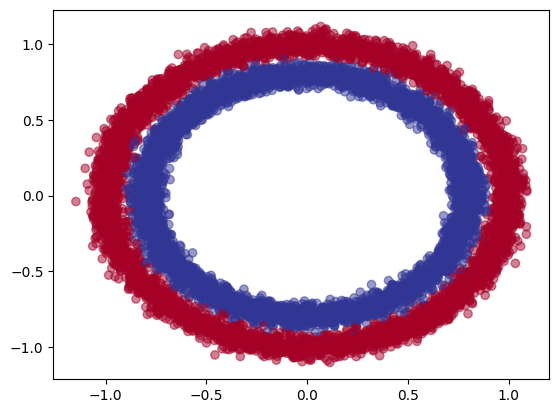

In [5]:
import matplotlib.pyplot as plt

plt.scatter(df['x1'],
            df['x2'],
            c = y,
            cmap = plt.cm.RdYlBu,
            alpha = 0.5)

## Converting the data into train test split

In [6]:
import torch as pt

type(x), x.dtype

(numpy.ndarray, dtype('float64'))

In [7]:
# Turn data into tensor
x = pt.from_numpy(x).type(pt.float)
y = pt.from_numpy(y).type(pt.float)

x[:5], y[:5]

(tensor([[ 0.0626,  0.8330],
         [ 1.0327, -0.4489],
         [-0.5885,  0.7851],
         [ 0.9971, -0.3274],
         [ 0.8318, -0.5409]]),
 tensor([1., 0., 0., 0., 0.]))

Splitting the data into train, test data

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = len(x))

x_train.shape, y_test.shape

(torch.Size([8000, 2]), torch.Size([2000]))

### Building the model

In [9]:
device = 'cuda' if pt.cuda.is_available() else 'cpu'
device

'cpu'

In [10]:
import torch as pt
from torch import nn
from torch import optim

In [11]:
class ClassificationModel (nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer2 = nn.Linear(in_features = 10, out_features = 5)
        self.layer3 = nn.Linear(in_features = 5, out_features = 1)

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

In [12]:
model0 = ClassificationModel().to(device)
model0


ClassificationModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=5, bias=True)
  (layer3): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(params = model0.parameters(),
                      lr = 0.1)

In [14]:
def acc_fn(y_true, y_pred):
    correct = pt.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_true))*100
    return acc


### Training the model

In [15]:
model0.eval()
with pt.inference_mode():
    y_logits = model0(x_test.to(device))[:5]
y_logits

tensor([[0.1181],
        [0.3737],
        [0.4469],
        [0.1299],
        [0.2117]])

In [16]:
y_pred_prob = pt.sigmoid(y_logits)
y_pred = pt.round(y_pred_prob)
y_pred_labels = pt.round(pt.sigmoid(model0(x_test.to(device))[:5]))

pt.eq(y_pred.squeeze(), y_pred_labels.squeeze())

tensor([True, True, True, True, True])

### Training and Testing Loop

In [17]:
pt.manual_seed(42)
pt.cuda.manual_seed(42)

epochs = 100
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

In [18]:
for epoch in range(epochs):
    # Training
    model0.train()

    # Forward pass
    y_logits = model0(x_train).squeeze()
    y_pred = pt.round(pt.sigmoid(y_logits))

    # calc loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_true = y_train, y_pred = y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward   -> Back prop
    loss.backward()

    # optimizer step  -> Gradient Decent
    optimizer.step()

    # Testing
    model0.eval()
    with pt.inference_mode():
        # Forward pass
        test_logits = model0(x_test).squeeze()
        test_pred = pt.round(pt.sigmoid(test_logits))

        # calculating the test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(y_test, test_pred)

    if epoch % 10==0:
        print(f"epoch: {epoch} | Loss : {loss : .4f} , Acc: {acc: .2f}, test_loss : {test_loss: .4f}, test_acc : {test_acc: .2f}")

epoch: 0 | Loss :  0.7027 , Acc:  50.35, test_loss :  0.7094, test_acc :  48.60
epoch: 10 | Loss :  0.6973 , Acc:  56.41, test_loss :  0.7025, test_acc :  56.35
epoch: 20 | Loss :  0.6952 , Acc:  53.99, test_loss :  0.6993, test_acc :  52.00
epoch: 30 | Loss :  0.6943 , Acc:  52.62, test_loss :  0.6977, test_acc :  50.55
epoch: 40 | Loss :  0.6939 , Acc:  51.78, test_loss :  0.6967, test_acc :  50.25
epoch: 50 | Loss :  0.6936 , Acc:  51.66, test_loss :  0.6960, test_acc :  50.30
epoch: 60 | Loss :  0.6935 , Acc:  51.40, test_loss :  0.6956, test_acc :  49.90
epoch: 70 | Loss :  0.6934 , Acc:  51.45, test_loss :  0.6953, test_acc :  49.70
epoch: 80 | Loss :  0.6933 , Acc:  51.31, test_loss :  0.6950, test_acc :  49.45
epoch: 90 | Loss :  0.6932 , Acc:  51.32, test_loss :  0.6948, test_acc :  49.25


### Predection and Evaluation

In [22]:
import requests
from pathlib import Path


if Path('helper_functions.py').is_file():
    print('Helper function already exits')
else :
    print('Download helper funciton')
    req = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functionspy')
    with open('helper_functions.py', 'wb') as f:
        f.write(req.content)

Helper function already exits


In [29]:
# import helper_functions as hf

### Improving the model

In [30]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2, out_features= 10)
        self.layer2 = nn.Linear(in_features = 10, out_features = 16)
        self.layer3 = nn.Linear(in_features = 16, out_features = 1)

    def forward(self, x):
        z = self.layer1(x)
        z = self.layer2(z)
        z = self.layer3(z)

        return z;

In [31]:
model1 = CircleModelV2().to(device)
model1

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
)

In [32]:
model1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310

In [33]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params = model1.parameters(), lr = 0.1)

In [36]:
pt.manual_seed(42)
pt.cuda.manual_seed(42)

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    # Training
    model1.train()

    # 1. Forward pass
    y_logits = model1(x_train).squeeze()
    y_pred = pt.round(pt.sigmoid(y_logits))

    # 2. Calc Loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_train, y_pred)

    # 3. Optimizer
    optimizer.zero_grad()

    # 4. Loss Backward -> Back prop
    loss.backward()

    # 5. Gradient Decent
    optimizer.step()

    # Testing
    model1.eval()
    with pt.inference_mode():
        # 1. Forward Pass
        test_logits = model1(x_test).squeeze()
        test_pred = pt.round(pt.sigmoid(test_logits))

        # 2. Clac Loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn (test_pred, y_test)

    if epoch %100 == 0:
        print(f"epoch: {epoch} | Loss : {loss : .4f} , Acc: {acc: .2f}, test_loss : {test_loss: .4f}, test_acc : {test_acc: .2f}")

epoch: 0 | Loss :  0.7061 , Acc:  49.65, test_loss :  0.6987, test_acc :  51.40
epoch: 100 | Loss :  0.6931 , Acc:  51.39, test_loss :  0.6938, test_acc :  50.05
epoch: 200 | Loss :  0.6931 , Acc:  52.39, test_loss :  0.6938, test_acc :  49.70
epoch: 300 | Loss :  0.6931 , Acc:  52.62, test_loss :  0.6938, test_acc :  50.45
epoch: 400 | Loss :  0.6931 , Acc:  52.64, test_loss :  0.6938, test_acc :  50.65
epoch: 500 | Loss :  0.6931 , Acc:  52.68, test_loss :  0.6938, test_acc :  50.75
epoch: 600 | Loss :  0.6931 , Acc:  52.64, test_loss :  0.6938, test_acc :  50.90
epoch: 700 | Loss :  0.6931 , Acc:  52.65, test_loss :  0.6938, test_acc :  50.90
epoch: 800 | Loss :  0.6931 , Acc:  52.65, test_loss :  0.6938, test_acc :  50.90
epoch: 900 | Loss :  0.6931 , Acc:  52.65, test_loss :  0.6938, test_acc :  50.90


Not Plotint the decision boundary as the code is not working